## L2 正则化

（需要补充说明文字）

- 问题1： 计算dW中是否需要考虑正则项呢？

【错误观点】只需要在计算损失函数考虑即可
    
【正确观点】不仅损失函数时需要考虑，而且在反向传播过程中也要考虑

<img src="my_files/l2_regu.png" >


- 代码实现：将之前自己编写的代码直接修改得到，而不是用官方教程的代码

- 代码架构
    - 正则化的代码
    - dropout的代码

In [41]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
import scipy.io

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

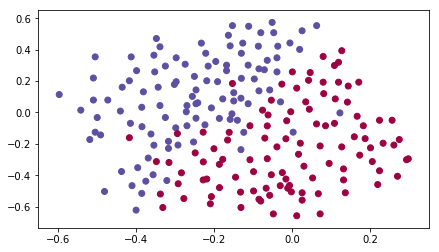

In [42]:
def load_2D_dataset():
    data=scipy.io.loadmat("datasets/data.mat")
    train_X,train_Y,test_X,test_Y=data['X'].T,data['y'].T,data['Xval'].T,data['yval'].T
    plt.scatter(x=train_X[0],y=train_X[1],c=np.squeeze(train_Y),cmap=plt.cm.Spectral)
    return train_X,train_Y,test_X,test_Y
train_X,train_Y,test_X,test_Y=load_2D_dataset()

## 1 L2正则化

- 初始化选择he初始化方法

In [43]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """        
    A=1/(1+np.exp(-Z))
    cache=Z
    return A,cache
def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """    
    A=np.maximum(0,Z)
    assert(A.shape==Z.shape)
    cache=A
    return A,cache


def sigmoid_backward(dA,cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """    
    Z=cache
    s=1/(1+np.exp(-Z))
    dZ=dA*s*(1-s)
    assert (dZ.shape==Z.shape)
    return dZ

def relu_backward(dA,cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """    
    Z=cache
    dZ=np.array(dA,copy=True)
    dZ[Z<=0]=0
    assert(dZ.shape==Z.shape)
    return dZ


# linaer
def linear_forward(A_prev,W,b):
    """
    linear forward
    

    Parameters
    ----------
    A : 上一层的activation
    W : 权重
    b : bias
    
    Returns
    -------
    Z : pre-activation
    cache : tuple of  A,W,b
        
    """    
    Z=np.matmul(W,A_prev)+b
    assert (Z.shape==(W.shape[0],A_prev.shape[1]))
    cache=(A_prev,W,b,Z)
    return Z,cache


# linear activation
def linear_activation_forward(A_prev,W,b,activation):
    """
    线性激活单元
    
    Parameters
    ----------
    A_prev :上一层激活值
    W : 权重值
    b : bias
    activation: sigmoid or relu

    Returns
    -------
    A : 激活值
    cache: linear_cache,activation_cache            
    """    
    
    if activation=='relu':    
        Z, linear_cache = linear_forward(A_prev, W, b)
        A,activation_cache=relu(Z)
    elif activation=='sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A,activation_cache=sigmoid(Z)        
        
    assert (A.shape==(W.shape[0],A_prev.shape[1]))
    cache=(linear_cache,activation_cache)
    return A,cache
    
    

# L层forward模型 L-1层sigmoid 1层relu
def L_model_forward(X,parameters):
    """
    正向传播(L-1线性+Relu，L 线性+Sigmoid)
    

    Parameters
    ----------
    X : 输入
    parameters : 参数 W b L层

    Returns
    -------
    AL : L层激活值
    caches : 每一层的cache(linear+activation)
            
    """
    L=len(parameters)//2
    A_prev=X.copy()
    caches=[]
    for l in range(1,L):
        W=parameters['W{}'.format(l)]
        b=parameters['b{}'.format(l)]
        A_prev,cache=linear_activation_forward(A_prev, W, b, activation = "relu")
        caches.append(cache)
    WL=parameters['W{}'.format(L)]
    bL=parameters['b{}'.format(L)] 
    AL,cache=linear_activation_forward(A_prev, WL, bL, activation = "sigmoid")
    caches.append(cache)
    assert(AL.shape==(1,X.shape[1]))
    return AL,caches
    
    
def initialize_with_layers(layers_dims,initialization='he'):
    """
    Parameters
    ----------
    layers_dims : 从输入层到输出层的各层神经元个数
    method: zero, random,he

    Returns
    -------
    parameters : 
            
    """

    
    L=len(layers_dims)-1
    parameters={}
    if initialization=='zero':
        for l in range(1,L+1):
            parameters['W{}'.format(l)]=np.zeros((layers_dims[l],layers_dims[l-1]))
            parameters['b{}'.format(l)]=np.zeros((layers_dims[l],1))
        return parameters
                
    elif initialization=='random':
        np.random.seed(3)        
        for l in range(1,L+1):
            parameters['W{}'.format(l)]=np.random.randn(layers_dims[l],layers_dims[l-1])*10
            parameters['b{}'.format(l)]=np.zeros((layers_dims[l],1))
        return parameters
        
    elif  initialization=='he':
        np.random.seed(3)          
        for l in range(1,L+1):
            parameters['W{}'.format(l)]=np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(2.0/layers_dims[l-1])
            parameters['b{}'.format(l)]=np.zeros((layers_dims[l],1))
        return parameters                            

In [44]:
def compute_cost_with_regularization(AL,Y,paramters,lambd):
    """
    计算损失函数
    
    Parameters
    ----------
    AL:  
    Y : 
    lamda 正则化项系数

    Returns
    -------
    cost :         
    """
    m=Y.shape[1]
    L=len(paramters)//2
    cost=-(np.dot(np.log(AL.ravel()),Y.ravel())+np.dot((np.log(1-AL.ravel())),1-Y.ravel()))/m 
    for l in range(1,L+1):          
        cost+= np.sum( (paramters['W{}'.format(l)]**2))*lambd/2.0/m
    
    # dim check
    assert( isinstance(cost,float))    
    return cost





#### 结果计算错误：原因分析（忘了用 平方项）

In [45]:
def compute_cost_with_regularization_test_case():
    np.random.seed(1)
    Y_assess = np.array([[1, 1, 0, 1, 0]])
    W1 = np.random.randn(2, 3)
    b1 = np.random.randn(2, 1)
    W2 = np.random.randn(3, 2)
    b2 = np.random.randn(3, 1)
    W3 = np.random.randn(1, 3)
    b3 = np.random.randn(1, 1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    a3 = np.array([[ 0.40682402,  0.01629284,  0.16722898,  0.10118111,  0.40682402]])
    return a3, Y_assess, parameters

A3, Y_assess, parameters = compute_cost_with_regularization_test_case()
print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


#### 反向传播

In [105]:
def linear_backward(dZ,cache,lambd=0):
    """
    线性反向传播
    

    Parameters
    ----------
    dZ : 
    cache : linear cache A,W,b

    Returns
    -------
    dW :
    db :
    dA_prev : 
    """    
    A_prev,W,b,Z=cache
    m=A_prev.shape[1]


    
    dW=np.matmul(dZ,A_prev.T)/m+lambd*W/m  
    db=np.sum(dZ,axis=1,keepdims=True)/m    
    dA_prev=np.matmul(W.T,dZ)

    assert(dW.shape==(W.shape))
    assert(db.shape==(b.shape))
    assert(dA_prev.shape==A_prev.shape )   
    
    return dA_prev,dW,db
    
    
def linear_activation_backward(dA,cache,activation,lambd=0):
    """
    反向传播
    

    Parameters
    ----------
    dA :
    cache: activation_cache,linear_cache
    activation: relu sigmoid

    Returns
    -------
    dW :
    db :
    dA_prev : 
        
    """
    linear_cache,activation_cache=cache
    if activation=='relu':
        dZ=relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache,lambd)
    elif activation=='sigmoid':
        dZ=sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache,lambd)        
    return dA_prev, dW, db,dZ   

def L_model_backward(AL,Y,caches,lambd):
    """
    backward propagation

    Parameters
    ----------
    AL : L层激活值
    Y : 
    caches : 每一层的cache(linear+activation)

    Returns
    -------
    grads: dA dW db 
    """
    

    L=len(caches)
    grads={}
        
    dAL=-np.divide(Y,AL)+np.divide(1-Y,1-AL)
    grads["dA{}".format(L)]=dAL
    current_cache=caches[-1]    
 
    grads["dA{}".format(L-1)], grads['dW{}'.format(L)],grads['db{}'.format(L)],grads['dZ{}'.format(L)],=linear_activation_backward(dAL, current_cache, activation = "sigmoid",lambd=lambd)   

    for l in reversed(range(1,L)):          
        current_cache=caches[l-1]
        dA_prev_temp, dW_temp, db_temp,dZ_temp = linear_activation_backward(grads["dA{}".format(l)], current_cache, activation = "relu",lambd=lambd)    
        grads["dA{}".format(l-1)]=dA_prev_temp        
        grads['dW{}'.format(l)]=dW_temp
        grads['db{}'.format(l)]=db_temp
        grads['dZ{}'.format(l)]=dZ_temp        
    return grads
    
    
    

def update_parameters(parameters,grads,learning_rate):
    """
    参数更新
    

    Parameters
    ----------
    parameters : 所有参数 
        W1~WL : 权重 (layer_dims[1],layer_dims[1-1])
        b1~bL : bias (layer_dims[1],1) 
    grads: dA dW db 

    Returns
    -------
    parameters : 所有参数 
        W1~WL : 权重 (layer_dims[1],layer_dims[1-1])
        b1~bL : bias (layer_dims[1],1) 

    """    
    L=len(parameters)//2
    for l in range(1,L+1):
        W_temp,b_temp=parameters['W{}'.format(l)],parameters['b{}'.format(l)]        
        dW_temp,db_temp=grads['dW{}'.format(l)],grads['db{}'.format(l)]        
        parameters['W{}'.format(l)],parameters['b{}'.format(l)]=W_temp-learning_rate*dW_temp,b_temp-learning_rate*db_temp
    return parameters    
    

#### 调试遇到问题
- 维度检查错误：linear_cache的顺序为(A2,W3,b3,Z3) 而不是 (A2,Z2,W3,b3)
    - 快速方法： 将测试图画在纸上，检查出现问题的地方
- dW3计算错误，而dW1和的dW2计算正确
    - 错误结果 `dW3 = [[-1.68070958  0.          0.        ]]`
    - 正确结果 `dW3	[[-1.77691347 -0.11832879 -0.09397446]]`
    - 快速解决： 公式重算，发现没有dW3没有加上正则项;部分有加正则项，部分没有加正则项，可以推测第一次反向传播时没有加正则化项
                


In [106]:
def backward_propagation_with_regularization_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(3, 5)
    Y_assess = np.array([[1, 1, 0, 1, 0]])
    cache = (np.array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
         [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]),
  np.array([[ 0.        ,  3.32524635,  2.13994541,  2.60700654,  0.        ],
         [ 0.        ,  4.1600994 ,  0.79051021,  1.46493512,  0.        ]]),
  np.array([[-1.09989127, -0.17242821, -0.87785842],
         [ 0.04221375,  0.58281521, -1.10061918]]),
  np.array([[ 1.14472371],
         [ 0.90159072]]),
  np.array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
         [-0.69166075, -3.47645987, -2.25194702, -2.65416996, -0.69166075],
         [-0.39675353, -4.62285846, -2.61101729, -3.22874921, -0.39675353]]),
  np.array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]),
  np.array([[ 0.50249434,  0.90085595],
         [-0.68372786, -0.12289023],
         [-0.93576943, -0.26788808]]),
  np.array([[ 0.53035547],
         [-0.69166075],
         [-0.39675353]]),
  np.array([[-0.3771104 , -4.10060224, -1.60539468, -2.18416951, -0.3771104 ]]),
  np.array([[ 0.40682402,  0.01629284,  0.16722898,  0.10118111,  0.40682402]]),
  np.array([[-0.6871727 , -0.84520564, -0.67124613]]),
  np.array([[-0.0126646]]))
    return X_assess, Y_assess, cache

X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()
(Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

caches=[((X_assess,W1,b1,Z1),Z1),((A1,W2,b2,Z2),Z2),((A2,W3,b3,Z3),Z3)]

grads = L_model_backward(A3, Y_assess, caches, lambd = 0.7)
print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("dW3 = "+ str(grads["dW3"]))

dW1 = [[-0.25604647  0.1229883  -0.28297132]
 [-0.17706304  0.345361   -0.44105717]]
dW2 = [[ 0.79276497  0.85133932]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = [[-1.77691375 -0.11832879 -0.09397446]]


In [116]:
def L_layer_model(X,y,layers_dims,initialization='he',learning_rate=0.3,lambd=0.7,num_iterations=30000,print_cost=False):
    """
            
    组成模型
    
    Parameters
    ----------
    X: input data
    Y :真实值
    learning_rate: 学习率
    layers_dims : 参数
    num_iterations： 循环次数
    print_cost : 是否打印cost

    Returns
    -------
    parameters :  dict形式
        W1 (n_h,n_x)
        b1 (n_h,1)
        W2 (n_y,n_h)
        b2 (n_y,1) 
    costs:  
    
            
    """     
    
    np.random.seed(1)
    
    #     参数初始化
    parameters = initialize_with_layers(layers_dims,initialization)

    #     循环
    costs=[]
    for i in range(num_iterations):
        #         正向传播
        AL,caches=L_model_forward(X,parameters)    
        #         反向传播
        
        grads=L_model_backward(AL, y, caches,lambd=lambd)        
        #         参数更新
        parameters=update_parameters(parameters,grads,learning_rate) 
        
        #  计算损失函数 
        if( i%100==0) :        
            cost=compute_cost_with_regularization(AL,y,parameters,lambd)
            costs.append(cost)
            if( i%100==0) and( print_cost==True):
                print("cost after {} iterations, cost={}".format(i,cost))
    plt.plot(np.squeeze(costs))
    plt.xlabel("cost")
    plt.ylabel("iterations per hundred")
    plt.title("learnint rate={}".format(learning_rate))
    plt.show()
    
    return parameters,costs


#### 出现错误
```
     15     m=Y.shape[1]
     16     L=len(paramters)//2
---> 17     cost=-(np.dot(np.log(AL.ravel()),Y.ravel())+np.dot((np.log(1-AL.ravel())),1-Y.ravel()))/m
     18     for l in range(1,L+1):
     19         cost+= np.sum( (paramters['W{}'.format(l)]**2))*lambd/2.0/m

ipdb> np.dot(np.log(AL.ravel()),Y.ravel())
*** ValueError: shapes (211,) and (5,) not aligned: 211 (dim 0) != 5 (dim 0)
ipdb> Y.ravel().shape
```

In [132]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    
#     from IPython.core.debugger import Tracer; Tracer()()

    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral,alpha=0.5)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def predict(X,y,parameters):
    """
    预测
    
    Parameters
    ----------
    X : 
    y : 
    parameters: 模型参数

    Returns
    -------
    y_hat : 预测值            
    """
    m=y.shape[1]
    AL,caches=L_model_forward(X,parameters)
    y_hat=(AL>0.5)
    print("accuracy={:,.2%}".format(np.sum(y_hat==y)/m))
    
    return y_hat


def predict_dec(X,parameters):
    """
    预测
    
    Parameters
    ----------
    X : 
    y : 
    parameters: 模型参数

    Returns
    -------
    y_hat : 预测值            
    """
    AL,caches=L_model_forward(X,parameters)
    y_hat=(AL>0.5)
    
    return y_hat

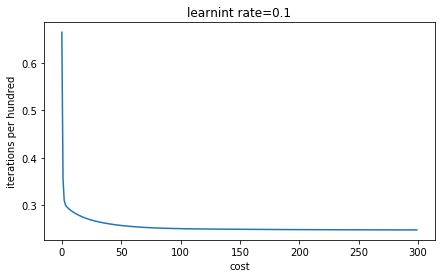

accuracy=94.79%
accuracy=95.50%


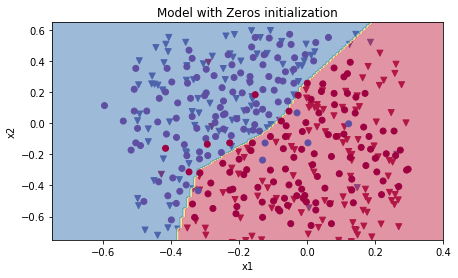

In [151]:
parameters,costs=L_layer_model(train_X,train_Y,layers_dims=[train_X.shape[0],20,3,1],initialization='he',learning_rate=0.1,lambd=0.5,num_iterations=30000,print_cost=False)
prediction_train=predict(train_X,train_Y,parameters)
prediction_test=predict(test_X,test_Y,parameters)
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plt.scatter(test_X[0, :], test_X[1, :], c=np.squeeze(test_Y), cmap=plt.cm.Spectral,marker='v')
plot_decision_boundary(lambda x:predict_dec(x.T,parameters) ,train_X,np.squeeze(train_Y))


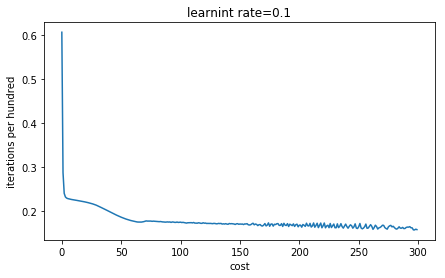

accuracy=92.42%
accuracy=94.00%


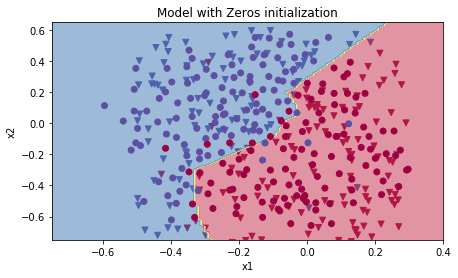

In [150]:
parameters,costs=L_layer_model(train_X,train_Y,layers_dims=[train_X.shape[0],20,3,1],initialization='he',learning_rate=0.1,lambd=0,num_iterations=30000,print_cost=False)
prediction_train=predict(train_X,train_Y,parameters)
prediction_test=predict(test_X,test_Y,parameters)
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plt.scatter(test_X[0, :], test_X[1, :], c=np.squeeze(test_Y), cmap=plt.cm.Spectral,marker='v')
plot_decision_boundary(lambda x:predict_dec(x.T,parameters) ,train_X,np.squeeze(train_Y))


### 结论：可以发现有正则化项的 decision boundary 更加平滑